In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.neighbors as skn
import sklearn.ensemble as ske
import sklearn.metrics as skm
import sklearn.covariance as skc
import sklearn.svm as sks
import ensemble

In [2]:
def plot_roc(y_true, y_score, title=''):
    fpr, tpr, thresholds = skm.roc_curve(y_true=y_true, y_score=y_score)
    auc = skm.roc_auc_score(y_true=y_true, y_score=y_score)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title+' (AUC = {})'.format(auc))
    plt.show()
    return auc

In [3]:
def get_lof_optimal_k(x, y, k_min=2, k_max=50, plot=True):
    '''
    find optimal neighborhood size for LOF
    '''
    n = []
    a = []
    for n_neighbors in range(k_min, k_max+1):
        n.append(n_neighbors)
        lof = skn.LocalOutlierFactor(n_neighbors=n_neighbors)
        res = lof.fit(x)
        auc = skm.roc_auc_score(
            y_true=y,
            y_score=np.abs(res.negative_outlier_factor_)
        )
        a.append(auc)
        
    if plot:
        plt.plot(n,a)
        plt.xlabel('k')
        plt.ylabel('ROC AUC')
        plt.title('Optimal neighborhood size for LOF')
        plt.show()
        
    return n[np.argmax(a)]

In [4]:
def get_mcd_optimal_contamination(
    x, y, contamination_min=0.05, contamination_max=0.5, contamination_steps=0.01,
    plot=True
):
    '''
    find optimal contamination for mcd
    '''
    val = []
    auc = []
    for contamination in np.arange(contamination_min, contamination_max, contamination_steps):
        mcd = skc.EllipticEnvelope(contamination=contamination)
        res = mcd.fit(x)
        a = skm.roc_auc_score(
            y_true=y,
            y_score=np.abs(res.score_samples(x))
        )
        auc.append(a)
        val.append(contamination)
        
    if plot:
        plt.plot(val,auc)
        plt.xlabel('contamination')
        plt.ylabel('ROC AUC')
        plt.title('Optimal contamination for MCD')
        plt.show()
        
    return val[np.argmax(auc)], auc[np.argmax(auc)]

In [5]:
def get_iforest_optimal_contamination(
    x, y, contamination_min=0.05, contamination_max=0.5, contamination_steps=0.01,
    plot=True
):
    '''
    find optimal contamination for mcd
    '''
    val = []
    auc = []
  
    for contamination in np.arange(contamination_min, contamination_max, contamination_steps):
        iforest = ske.IsolationForest(n_jobs=-1, contamination=contamination)
        res = iforest.fit(x)
        a = skm.roc_auc_score(
            y_true=y,
            y_score=np.abs(iforest.score_samples(x))
        )
        auc.append(a)
        val.append(contamination)
        
    if plot:
        plt.plot(val,auc)
        plt.xlabel('contamination')
        plt.ylabel('ROC AUC')
        plt.title('Optimal contamination for Isolation forest')
        plt.show()
        
    return val[np.argmax(auc)], auc[np.argmax(auc)]

In [6]:
# note: ROC AUC appears to fluctuate with changing the contamination factor
# for MCD and Isolation Forest, but the fluctuations do not seem to follow
# a meaningful trend. Therefore optimizing contamination for these
# detectors may not be very meaningful and will be skipped for now
# in the interest of making calculations faster

In [7]:
def run_comparisons(df, variables, label, plot=True, use_minmax_normalization=False):
    auc_dict = {}
    # lof
    k = get_lof_optimal_k(df[variables], df[label], plot=plot)
    print('using k = {} as the optimal neighbourhood size for LOF'.format(k))
    lof = skn.LocalOutlierFactor(n_neighbors=k)
    res = lof.fit(df[variables])
    df['lof'] = np.abs(res.negative_outlier_factor_)
    
    # isolation forest
    iforest = ske.IsolationForest(n_jobs=-1)
    res = iforest.fit(df[variables])
    df['iforest'] = np.abs(res.score_samples(df[variables]))
  
    # mcd
    mcd = skc.EllipticEnvelope(contamination=0.1)
    res = mcd.fit(df[variables])
    df['mcd'] = np.abs(res.score_samples(df[variables]))

    # one class svd
    ocsvm = sks.OneClassSVM()
    res = ocsvm.fit(df[variables])
    df['ocsvm'] = 1/res.score_samples(df[variables])
    
    score_cols = ['lof', 'iforest', 'mcd', 'ocsvm']
    
    for x in score_cols:
        if plot:
            auc_dict[x] = plot_roc(df[label], df[x], title=x)
        else:
            auc_dict[x] = skm.roc_auc_score(df[label], df[x])
            
    if use_minmax_normalization:
        for x in score_cols:
            df[x+'_std'] = ensemble.Normalize().minmax_norm(df[x])    
    else:
        for x in score_cols:
            df[x+'_std'] = ensemble.Normalize().std_norm(df[x])
        
    score_cols = [x+'_std' for x in score_cols]
               
    # aggregation
    df = ensemble.Ensemble().rank_avg_ensemble(df, score_cols)
    df['rank_avg_score'] = 1/df['rank_avg']
    df = ensemble.Ensemble().avg_ensemble(df, score_cols)
    df = ensemble.Ensemble().maxpool_ensemble(df, score_cols)
    df = ensemble.Ensemble().thresholded_avg(df, score_cols)
    df = ensemble.Ensemble().threshold_pruned_avg_ensemble(df, score_cols)
    df = ensemble.Ensemble().top_k_pruned_avg_ensemble(df, score_cols)
    
    agg_cols = [
        'avg', 'maxpool', 'rank_avg_score', 'thresholded_avg',
        'threshold_pruned_avg', 'top_k_pruned_avg'
    ]
    for x in agg_cols:
        if plot:
            auc_dict[x] = plot_roc(df[label], df[x], title=x)
        else:
            auc_dict[x] = skm.roc_auc_score(df[label], df[x])
    return df, auc_dict

In [8]:
def data_reader(data_fname):
    df = pd.read_csv(data_fname, header=None)
    df.columns = ['x'+str(x) for x in df.columns]

    df = df.rename(columns={'x{}'.format(len(df.columns)-1): 'y'})
    df['y'] = df['y'].apply(lambda x: 0 if x=='n' else 1)
    
    variables = [x for x in df.columns if 'x' in x]
    
    return df, variables

# aloi-unsupervised-ad

In [9]:
data_fname = '/home/aras/data/unsupervised_anomaly_detection_benchmark_goldstein_markus/aloi-unsupervised-ad.csv'

df, variables = data_reader(data_fname)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x18,x19,x20,x21,x22,x23,x24,x25,x26,y
0,0.872812,0.000005,0.0,0.000036,0.0,0.0,0.0,0.0,0.0,0.050327,...,0.014212,0.000104,0.0,0.025490,0.004937,0.000011,0.000054,0.006804,0.015385,1
1,0.975206,0.000000,0.0,0.000651,0.0,0.0,0.0,0.0,0.0,0.007039,...,0.000000,0.000000,0.0,0.004853,0.001582,0.000000,0.000000,0.000201,0.000000,1
2,0.963777,0.000000,0.0,0.002005,0.0,0.0,0.0,0.0,0.0,0.006642,...,0.000000,0.000000,0.0,0.007828,0.002523,0.000000,0.000393,0.003800,0.000000,1
3,0.973246,0.000000,0.0,0.000556,0.0,0.0,0.0,0.0,0.0,0.008979,...,0.000000,0.000000,0.0,0.004392,0.000170,0.000000,0.000000,0.000007,0.000000,1
4,0.960720,0.000000,0.0,0.000656,0.0,0.0,0.0,0.0,0.0,0.013319,...,0.000000,0.000000,0.0,0.010299,0.000561,0.000000,0.000084,0.000264,0.000000,1


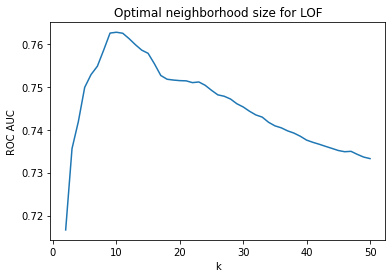

using k = 10 as the optimal neighbourhood size for LOF


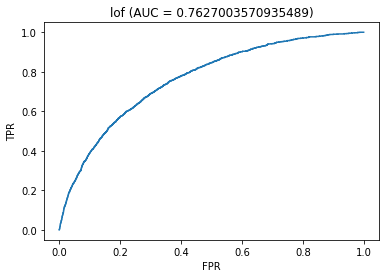

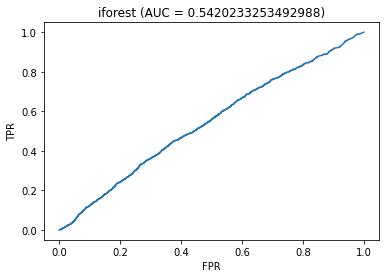

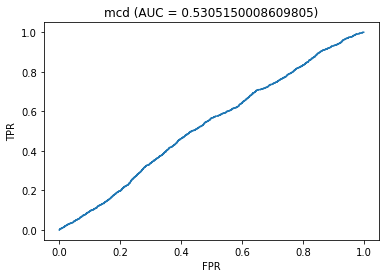

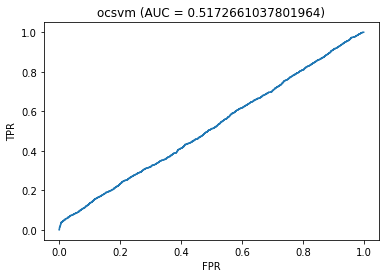

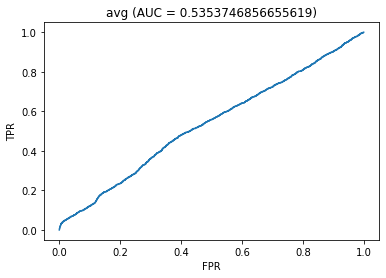

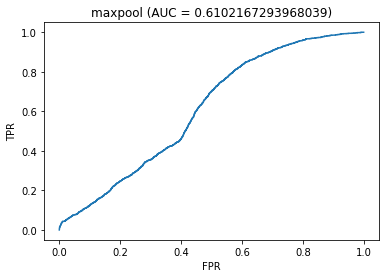

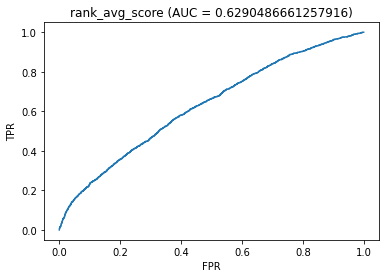

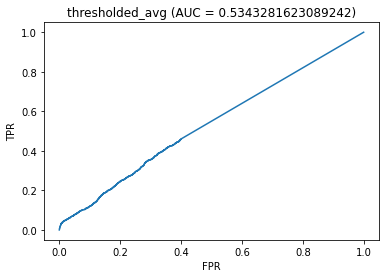

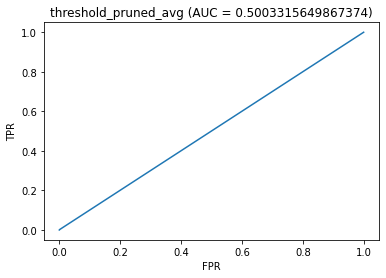

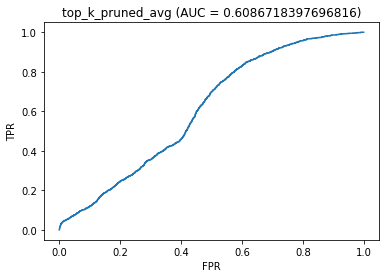

In [10]:
df, auc_aloi = run_comparisons(df, variables, 'y')

In [11]:
[(x, '{:.2f}'.format(auc_aloi[x])) for x in auc_aloi.keys()]

[('lof', '0.76'),
 ('iforest', '0.54'),
 ('mcd', '0.53'),
 ('ocsvm', '0.52'),
 ('avg', '0.54'),
 ('maxpool', '0.61'),
 ('rank_avg_score', '0.63'),
 ('thresholded_avg', '0.53'),
 ('threshold_pruned_avg', '0.50'),
 ('top_k_pruned_avg', '0.61')]

# annthyroid

In [13]:
data_fname = '/home/aras/data/unsupervised_anomaly_detection_benchmark_goldstein_markus/annthyroid-unsupervised-ad.csv'

df, variables = data_reader(data_fname)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061,0.006,0.023,0.087,0.026,1
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029,0.015,0.061,0.096,0.064,1
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.029,0.019,0.058,0.103,0.056,1
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.114,0.003,0.024,0.061,0.039,1
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.049,0.003,0.005,0.116,0.004,1


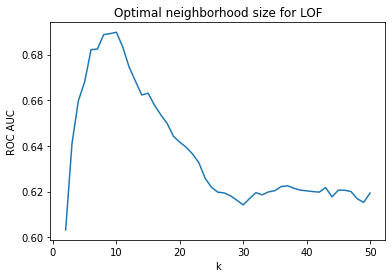

using k = 10 as the optimal neighbourhood size for LOF


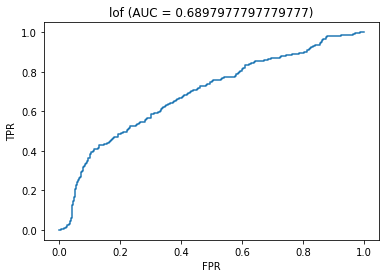

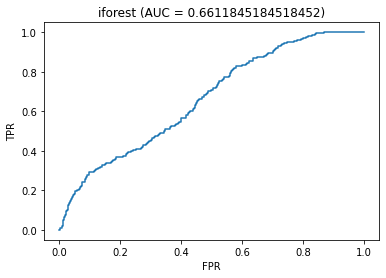

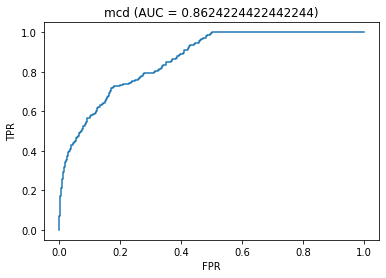

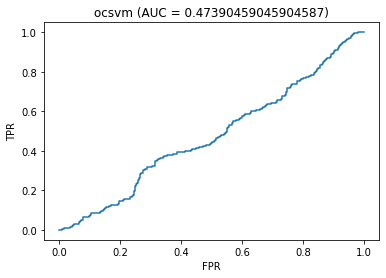

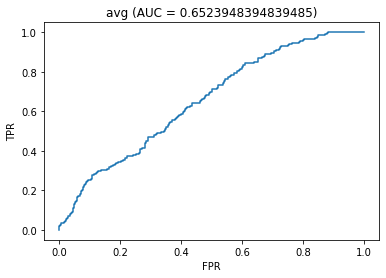

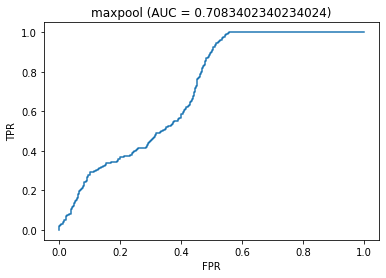

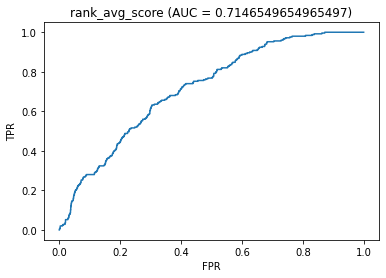

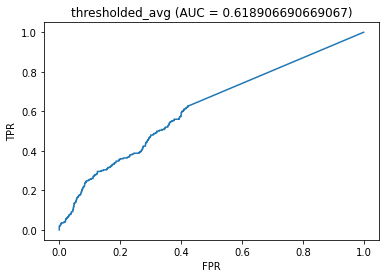

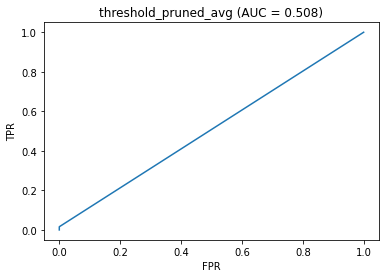

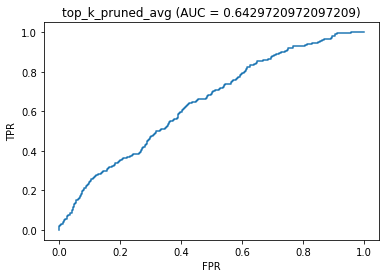

In [14]:
df, auc_annthyroid = run_comparisons(df, variables, 'y')

In [15]:
[(x, '{:.2f}'.format(auc_annthyroid[x])) for x in auc_annthyroid.keys()]

[('lof', '0.69'),
 ('iforest', '0.66'),
 ('mcd', '0.86'),
 ('ocsvm', '0.47'),
 ('avg', '0.65'),
 ('maxpool', '0.71'),
 ('rank_avg_score', '0.71'),
 ('thresholded_avg', '0.62'),
 ('threshold_pruned_avg', '0.51'),
 ('top_k_pruned_avg', '0.64')]

# breast cancer

In [16]:
data_fname = '/home/aras/data/unsupervised_anomaly_detection_benchmark_goldstein_markus/breast-cancer-unsupervised-ad.csv'

df, variables = data_reader(data_fname)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


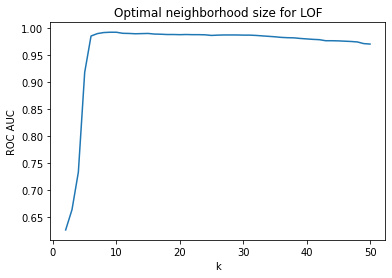

using k = 9 as the optimal neighbourhood size for LOF


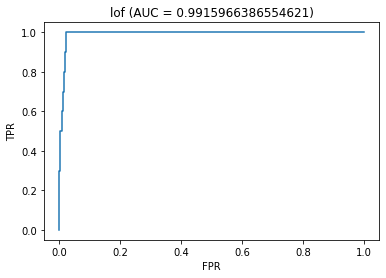

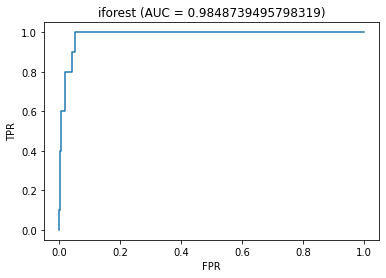

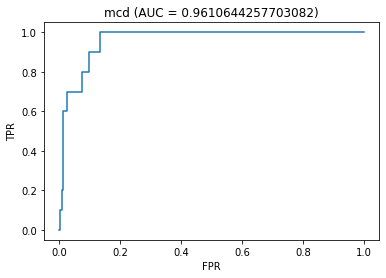

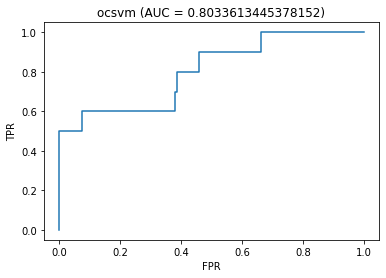

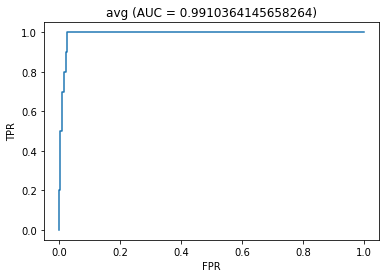

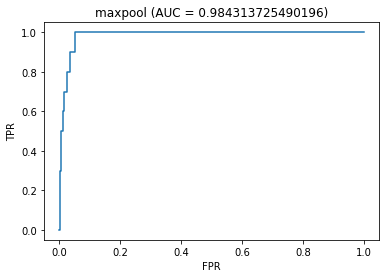

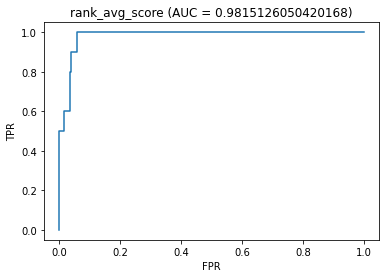

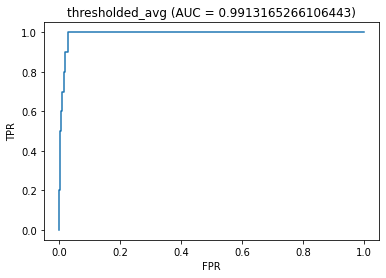

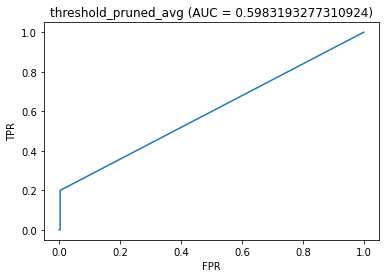

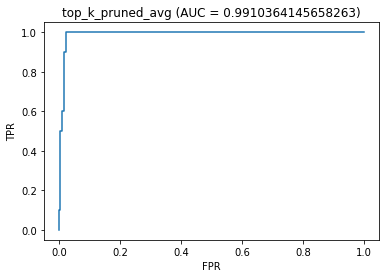

In [17]:
df, auc_breast_cancer = run_comparisons(df, variables, 'y')

In [18]:
[(x, '{:.6f}'.format(auc_breast_cancer[x])) for x in auc_breast_cancer.keys()]

[('lof', '0.991597'),
 ('iforest', '0.984874'),
 ('mcd', '0.961064'),
 ('ocsvm', '0.803361'),
 ('avg', '0.991036'),
 ('maxpool', '0.984314'),
 ('rank_avg_score', '0.981513'),
 ('thresholded_avg', '0.991317'),
 ('threshold_pruned_avg', '0.598319'),
 ('top_k_pruned_avg', '0.991036')]